# Notes

[Link](https://www.kaggle.com/abhinavjhanwar/movierecommender-collaborative-lightfm#Recommender-3:-Collaborative-Filtering)

Collaborative filters can further be classified into two types:

* `user-based filtering` - recommend products to a user that **similar** users have liked. If tony and jeris have a similar in games, and tony plays a new game and likes it, it is highly likely that jeris will like it to.

* `item-based filtering` - extremely similar to the content recommendation engine that you built. These systems identify similar items based on how people have rated it in the past. If tony and jeris gave 5 stars to LOTR and the Hobbit, the system identifies the items as similar, so if lehcar buys LOTR, the system will recommend the Hobbit.

In [1]:
import numpy as np
import pandas as pd 
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
data_path = '/Users/jeremy/data/movie_datasets/'

In [3]:
df_ratings = pd.read_csv(data_path + 'ratings.csv')
df_meta = pd.read_csv(data_path + 'movies_metadata.csv')

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


# Data Processing

In [5]:
df_meta.dropna(subset=['title'], inplace=True)

df_meta['id'] = pd.to_numeric(df_meta['id'])
df_meta['budget'] = pd.to_numeric(df_meta['budget'])
df_meta['popularity'] = pd.to_numeric(df_meta['popularity'])

df_meta['genres'] = df_meta['genres'].apply(literal_eval)

In [6]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45460 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45460 non-null  object 
 1   belongs_to_collection  4490 non-null   object 
 2   budget                 45460 non-null  int64  
 3   genres                 45460 non-null  object 
 4   homepage               7778 non-null   object 
 5   id                     45460 non-null  int64  
 6   imdb_id                45443 non-null  object 
 7   original_language      45449 non-null  object 
 8   original_title         45460 non-null  object 
 9   overview               44506 non-null  object 
 10  popularity             45460 non-null  float64
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45376 non-null  object 
 15  re

# Collaborative Filtering Recommender

## 1. Cosine Similarities

using mean of other user's weighted ratings based on similarity matrix

In [7]:
data = df_ratings.merge(df_meta[['id','title']], left_on='movieId', right_on='id')
data = data.drop(['id'],axis=1)

In [8]:
# get total counts for each movie
data['count'] = data.groupby('movieId').transform('count')['userId']
data.head()

,userId,movieId,rating,timestamp,title,count
0,1,110,1.0,1425941529,Three Colors: Red,66512
1,11,110,3.5,1231676989,Three Colors: Red,66512
2,22,110,5.0,1111937009,Three Colors: Red,66512
3,24,110,5.0,979870012,Three Colors: Red,66512
4,29,110,3.0,1044020005,Three Colors: Red,66512


In [9]:
# fetch top 100 movie ids based on count
top_n = 100
top_n_movie_id = data.drop_duplicates('movieId').sort_values('count', ascending=False)
top_n_movie_id = top_n_movie_id[:top_n]['movieId']

In [10]:
# filter out data according to the remaining movieIds
data = data[data['movieId'].isin(top_n_movie_id)].reset_index(drop=True)
data.head()

,userId,movieId,rating,timestamp,title,count
0,1,110,1.0,1425941529,Three Colors: Red,66512
1,11,110,3.5,1231676989,Three Colors: Red,66512
2,22,110,5.0,1111937009,Three Colors: Red,66512
3,24,110,5.0,979870012,Three Colors: Red,66512
4,29,110,3.0,1044020005,Three Colors: Red,66512


In [11]:
# fetch top 20000 users based on number of movies watched
top_n_users= 20000
user_id = data.drop_duplicates('userId').sort_values('count', ascending=False)
user_id = user_id[:top_n_users]['userId']

In [12]:
data = data[data.userId.isin(user_id)].reset_index(drop=True)
display(data.head())
display(data.shape)

,userId,movieId,rating,timestamp,title,count
0,40,260,4.0,862515493,The 39 Steps,77045
1,52,260,5.0,868514382,The 39 Steps,77045
2,81,260,5.0,1144384885,The 39 Steps,77045
3,86,260,4.0,1038314669,The 39 Steps,77045
4,99,260,5.0,866605992,The 39 Steps,77045


(126367, 6)

In [13]:
# create a user to movie rating matrix
df = data.pivot(index='userId', columns = 'movieId', values='rating')
df.head()

movieId,2,6,17,19,21,62,95,111,150,153,...,3114,3578,4011,4886,4896,4973,4993,4995,8961,44191
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN
52,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# replace NaN with average movie rating
df_imputed = df.fillna(df.mean(axis=0))
display(df_imputed.head())
display(df_imputed.shape)

movieId,2,6,17,19,21,62,95,111,150,153,...,3114,3578,4011,4886,4896,4973,4993,4995,8961,44191
userId,,,,,,,,,,,,,,,,,,,,,
10,3.386295,3.77193,4.048718,2.747012,3.663347,3.908467,3.400106,4.149944,4.000000,3.000000,...,3.985694,4.056351,4.173913,4.019506,3.995504,4.238863,4.219323,4.103819,4.054257,4.0
39,3.386295,3.77193,4.048718,2.747012,3.663347,3.908467,3.400106,4.149944,3.970114,3.116142,...,3.985694,4.056351,4.173913,4.019506,3.995504,4.238863,4.219323,4.103819,4.054257,4.0
40,3.386295,3.77193,4.048718,2.747012,3.663347,4.000000,3.000000,4.149944,3.970114,3.116142,...,3.985694,4.056351,4.173913,4.019506,3.995504,4.238863,4.219323,4.103819,4.054257,4.0
48,3.386295,3.77193,4.048718,2.747012,3.663347,3.908467,3.400106,4.149944,3.970114,3.116142,...,3.985694,4.056351,4.173913,4.019506,3.995504,4.238863,4.500000,4.103819,4.054257,4.0
52,3.386295,3.00000,4.048718,2.747012,3.663347,3.908467,3.000000,4.149944,3.970114,3.116142,...,3.985694,4.056351,4.173913,4.019506,3.995504,4.238863,4.219323,4.103819,4.054257,4.0


(20000, 90)

In [15]:
# compute similarity between all users
similarity_matrix = cosine_similarity(df_imputed.values)
df_similarity = pd.DataFrame(similarity_matrix, columns = df_imputed.index, index = df_imputed.index)
display(df_similarity.head())
display(df_similarity.shape)

userId,10,39,40,48,52,81,86,99,108,113,...,270811,270816,270821,270834,270863,270864,270865,270869,270870,270890
userId,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.993401,0.995250,0.996245,0.995759,0.995149,0.995612,0.995773,0.996291,0.995911,...,0.996290,0.996324,0.996290,0.993987,0.994313,0.996425,0.995065,0.992078,0.996422,0.996394
39,0.993401,1.000000,0.995465,0.995286,0.996006,0.995573,0.995659,0.996071,0.995292,0.996328,...,0.995303,0.996467,0.995303,0.994777,0.993410,0.996733,0.994937,0.992858,0.997590,0.996700
40,0.995250,0.995465,1.000000,0.998595,0.998573,0.997458,0.997741,0.997102,0.998625,0.998217,...,0.998620,0.998657,0.998620,0.996603,0.996646,0.998745,0.996998,0.994705,0.998679,0.998703
48,0.996245,0.995286,0.998595,1.000000,0.999123,0.998565,0.998863,0.999166,0.999965,0.999372,...,0.999970,0.999781,0.999970,0.997885,0.996369,0.999842,0.998126,0.995834,0.999595,0.999794
52,0.995759,0.996006,0.998573,0.999123,1.000000,0.998653,0.998184,0.998837,0.999058,0.999413,...,0.999150,0.999186,0.999150,0.997784,0.996834,0.999277,0.997536,0.995889,0.999212,0.999234


(20000, 20000)

In [16]:
def get_cf_recommendation(user_id: int):
    
    # get similarity scores for user
    sim_scores = df_similarity[user_id]
    
    # get movies that are unrated by user
    movie_ratings_for_user = df.T[user_id]
    movie_ratings_for_user_is_null = movie_ratings_for_user.isnull()
    unrated_movies_for_user = df.loc[df.index==user_id, movie_ratings_for_user_is_null]
    unrated_movies = unrated_movies_for_user.columns.tolist()
    
    # get weighted ratings of unrated movies by all other users
    movie_ratings = (df_imputed[unrated_movies].T * sim_scores).T
    
    # get top 100 similar users, skip current user
    sim_scores = sim_scores.sort_values(ascending=False)[1:101]
    
    movie_ratings = movie_ratings.mean(axis=0)
    movie_ratings = pd.DataFrame(movie_ratings,columns=['rating']).reset_index()
    
    recommended_movies = df_meta[['title','id']].merge(movie_ratings, left_on='id', right_on='movieId')
    recommended_movies = recommended_movies.sort_values('rating', ascending=False)
   
    return recommended_movies.head(10)

get_cf_recommendation(10)

,title,id,movieId,rating
35,The Million Dollar Hotel,318,318,4.387347
56,Murder She Said,750,750,4.351292
76,Local Color,2324,2324,4.332019
25,The Thomas Crown Affair,912,912,4.305155
34,The Man with the Golden Arm,541,541,4.300018
37,Under the Sand,4973,4973,4.214169
43,5 Card Stud,4993,4993,4.194866
29,The Talented Mr. Ripley,1213,1213,4.185461
0,Once Were Warriors,527,527,4.163613
20,Beetlejuice,4011,4011,4.149570


# 2. Surprise Package

In [24]:
df_ratings.head(2)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [73]:
from surprise import (
     Reader,
    Dataset,
    SVD,
    SVDpp,
    SlopeOne,
    NMF,
    NormalPredictor,
    KNNBaseline,
    KNNBasic,
    KNNWithMeans,
    KNNWithZScore,
    BaselineOnly,
    CoClustering
)
from surprise.model_selection import train_test_split, cross_validate
from tqdm import tqdm

In [23]:
ratings_count = df_ratings.rating.nunique()
ratings_count

10

In [163]:
reader = Reader(rating_scale=(0, ratings_count))
surprise_data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
surprise_train, surprise_test = train_test_split(surprise_data, test_size=0.25)

In [164]:
surprise_train.global_mean

3.8000949617515167

In [165]:
benchmark = []

for algorithm in tqdm([SVD(), SVDpp(),KNNBaseline(), CoClustering(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly()]):
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)
    df_results = pd.DataFrame.from_dict(results).mean(axis=0)
    df_results['algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(df_results)
    
df_benchmark = pd.DataFrame(benchmark).set_index('algorithm').sort_values('test_rmse', ascending=True)

 17%|███████████████████████▋                                                                                                                      | 2/12 [01:04<05:52, 35.23s/it]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 8/12 [06:28<01:45, 26.45s/it]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9/12 [09:47<04:01, 80.40s/it]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 10/12 [13:28<04:07, 123.75s/it]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 11/12 [17:47<02:45, 165.39s/it]

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [17:50<00:00, 89.17s/it]


In [166]:
df_benchmark

,test_rmse,fit_time,test_time
algorithm,,,
SVDpp,0.942103,15.034070,0.936184
KNNBaseline,0.943296,21.770014,58.129732
SVDpp,0.943825,15.419116,0.901115
BaselineOnly,0.951115,0.242035,0.215265
SVD,0.958544,4.648960,0.438784
KNNBasic,0.968225,17.693966,48.312821
SlopeOne,1.001774,0.221950,0.507080
KNNWithMeans,1.005946,18.966664,54.409512
KNNWithZScore,1.009656,21.930695,63.969896


<AxesSubplot:xlabel='test_rmse', ylabel='algorithm'>

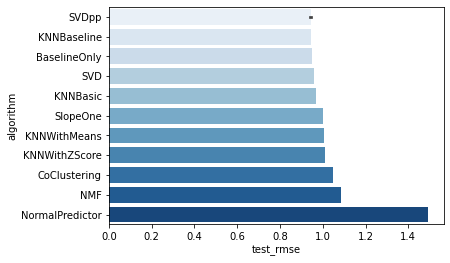

In [167]:
sns.barplot(data=df_benchmark, y=df_benchmark.index, x ='test_rmse', palette= 'Blues')

### SVD seems to be fast and also accurate

In [168]:
svd = SVD()
svd.fit(surprise_train)

In [169]:
def surprise_cf_recommender(alg, user_id: int, top_n: int = 10) -> pd.DataFrame:
    
    recommendations = pd.DataFrame()
    
    user_to_item_df = df.copy().reset_index()
    user_to_item_index = user_to_item_df[user_to_item_df.userId==user_id].index.item()
    
    unrated_movie_ids = user_to_item_df.iloc[user_to_item_index][user_to_item_df.iloc[user_to_item_index].isna()].index
    
    for movie_id in unrated_movie_ids:
        title = df_meta[df_meta.id == movie_id]['title'].item()
        rating = alg.predict(user_id, movie_id).est
        
        recommendations = recommendations.append([[user_id, movie_id, title, rating]])
        
    recommendations.columns = ['user_id','movie_id','title','rating']
    recommendations = recommendations.sort_values(by='rating', ascending=False)[:top_n].reset_index(drop=True)
    
    # add watched, top rated movie for user
    rated_movies = data[data.userId==1398].sort_values(by='rating', ascending=False)[:top_n]

    recommendations['top_rated_watched_movies'] = rated_movies['title'].values
    recommendations['rated'] = rated_movies['rating'].values
    
    return recommendations

surprise_cf_recommender(svd, 1398)

,user_id,movie_id,title,rating,top_rated_watched_movies,rated
0,1398,318,The Million Dollar Hotel,4.906816,The 39 Steps,5.0
1,1398,912,The Thomas Crown Affair,4.852065,48 Hrs.,5.0
2,1398,2324,Local Color,4.537250,Jurassic Park,5.0
3,1398,2028,Say Anything...,4.528280,Cockles and Muscles,5.0
4,1398,527,Once Were Warriors,4.487446,Sissi,5.0
5,1398,1213,The Talented Mr. Ripley,4.468049,Monsoon Wedding,5.0
6,1398,1961,My Name Is Bruce,4.442169,"Bang, Boom, Bang",4.0
7,1398,44191,Loose Screws,4.424343,The Passion of Joan of Arc,4.0
8,1398,1265,Bridge to Terabithia,4.422647,Rain Man,4.0
9,1398,541,The Man with the Golden Arm,4.413941,A Nightmare on Elm Street,4.0
